In [1]:
import fragmenter
from openeye import oechem, oedepict
import oenotebook as oenb

In [2]:
def highlight_bonds_with_label(mol_copy, fname, rotor=False, width=600, height=400, scale=1.0):
    """
    Generate image of molecule with highlighted bonds. The bonds can either be highlighted with a conjugation tag
    or if it is rotatable.

    Parameters
    ----------
    mol_copy: OEMol
    fname: str
        Name of image file
    conjugation: Bool, optional, Default is True
        If True, the bonds with conjugation tag set to True will be highlighted
    rotor: Bool, optional, Default is False
        If True, the rotatable bonds will be highlighted.
    width: int
    height: int
    label: string. Optional, Default is None
        The bond order label. The options are WibergBondOrder, Wiberg_psi4, Mayer_psi4.

    """
    mol = oechem.OEMol(mol_copy)
    
    dopt = oedepict.OEPrepareDepictionOptions()
    dopt.SetSuppressHydrogens(True)
    oedepict.OEPrepareDepiction(mol, dopt)

    opts = oedepict.OE2DMolDisplayOptions(width, height, oedepict.OEScale_AutoScale)
    opts.SetTitleLocation(oedepict.OETitleLocation_Hidden)
    
    disp = oedepict.OE2DMolDisplay(mol, opts)
    
    for bond in mol.GetBonds():
        if bond.IsRotor():
            atomBondSet = oechem.OEAtomBondSet()
            atomBondSet.AddBond(bond)
            atomBondSet.AddAtom(bond.GetBgn())
            atomBondSet.AddAtom(bond.GetEnd())
            
            # highlight bond
            hstyle = oedepict.OEHighlightStyle_BallAndStick
            hcolor = oechem.OEColor(oechem.OELimeGreen)
            oedepict.OEAddHighlighting(disp, hcolor, hstyle, atomBondSet) 
            
            # Add label that is offset of bond
            bond_label = oedepict.OEHighlightLabel("{:.2f}".format(bond.GetData('WibergBondOrder')))
            bond_label.SetFontScale(scale)
            oedepict.OEAddLabel(disp, bond_label, atomBondSet)
            

    return oedepict.OERenderMolecule(fname, disp)


In [3]:
lapatinib = 'CS(=O)(=O)CCNCc1ccc(o1)c2ccc3c(c2)c(ncn3)Nc4ccc(c(c4)Cl)OCc5cccc(c5)F'

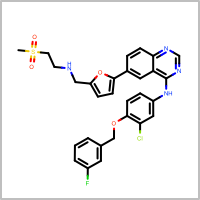

In [4]:
oenb.draw_smiles(lapatinib)

In [5]:
mol = fragmenter.chemi.smiles_to_oemol(lapatinib, name=' ', add_atom_map=True)
oechem.OEAddExplicitHydrogens(mol)
charged = fragmenter.chemi.get_charges(mol)

In [6]:
# Find rotatable bonds (use fragmenter engine)
f = fragmenter.fragment.WBOFragmenter(charged)
f._get_rotor_wbo()

In [7]:
for bond in mol.GetBonds():
    if bond.IsRotor():
        m1 = bond.GetBgn().GetMapIdx()
        m2 = bond.GetEnd().GetMapIdx()
        if (m1, m2) in f.rotors_wbo:
            bond.SetData('WibergBondOrder', f.rotors_wbo[(m1, m2)])

In [8]:
highlight_bonds_with_label(mol, fname='parent_molecule.pdf')

True

In [9]:
f.fragment(threshold=1.0)

In [10]:
f.depict_fragments('fragments_minimal.pdf')

True

In [11]:
f = fragmenter.fragment.WBOFragmenter(charged)
f.fragment(threshold=0.03)
f.depict_fragments('fragments_0.03.pdf')

True